Lambda School Data Science

*Unit 4, Sprint 3, Module 2*

---

# Convolutional Neural Networks (Prepare)

> Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers. *Goodfellow, et al.*

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe convolution and pooling
- <a href="#p2">Part 2: </a>Apply a convolutional neural network to a classification task
- <a href="#p3">Part 3: </a>Use a pre-trained convolution neural network for image classification

Modern __computer vision__ approaches rely heavily on convolutions as both a dimensionality reduction and feature extraction method. Before we dive into convolutions, let's talk about some of the common computer vision applications: 
* Classification [(Hot Dog or Not Dog)](https://www.youtube.com/watch?v=ACmydtFDTGs)
* Object Detection [(YOLO)](https://www.youtube.com/watch?v=MPU2HistivI)
* Pose Estimation [(PoseNet)](https://ai.googleblog.com/2019/08/on-device-real-time-hand-tracking-with.html)
* Facial Recognition [Emotion Detection](https://www.cbronline.com/wp-content/uploads/2018/05/Mona-lIsa-test-570x300.jpg)
* and *countless* more 

We are going to focus on classification and pre-trained classification today. What are some of the applications of image classification?

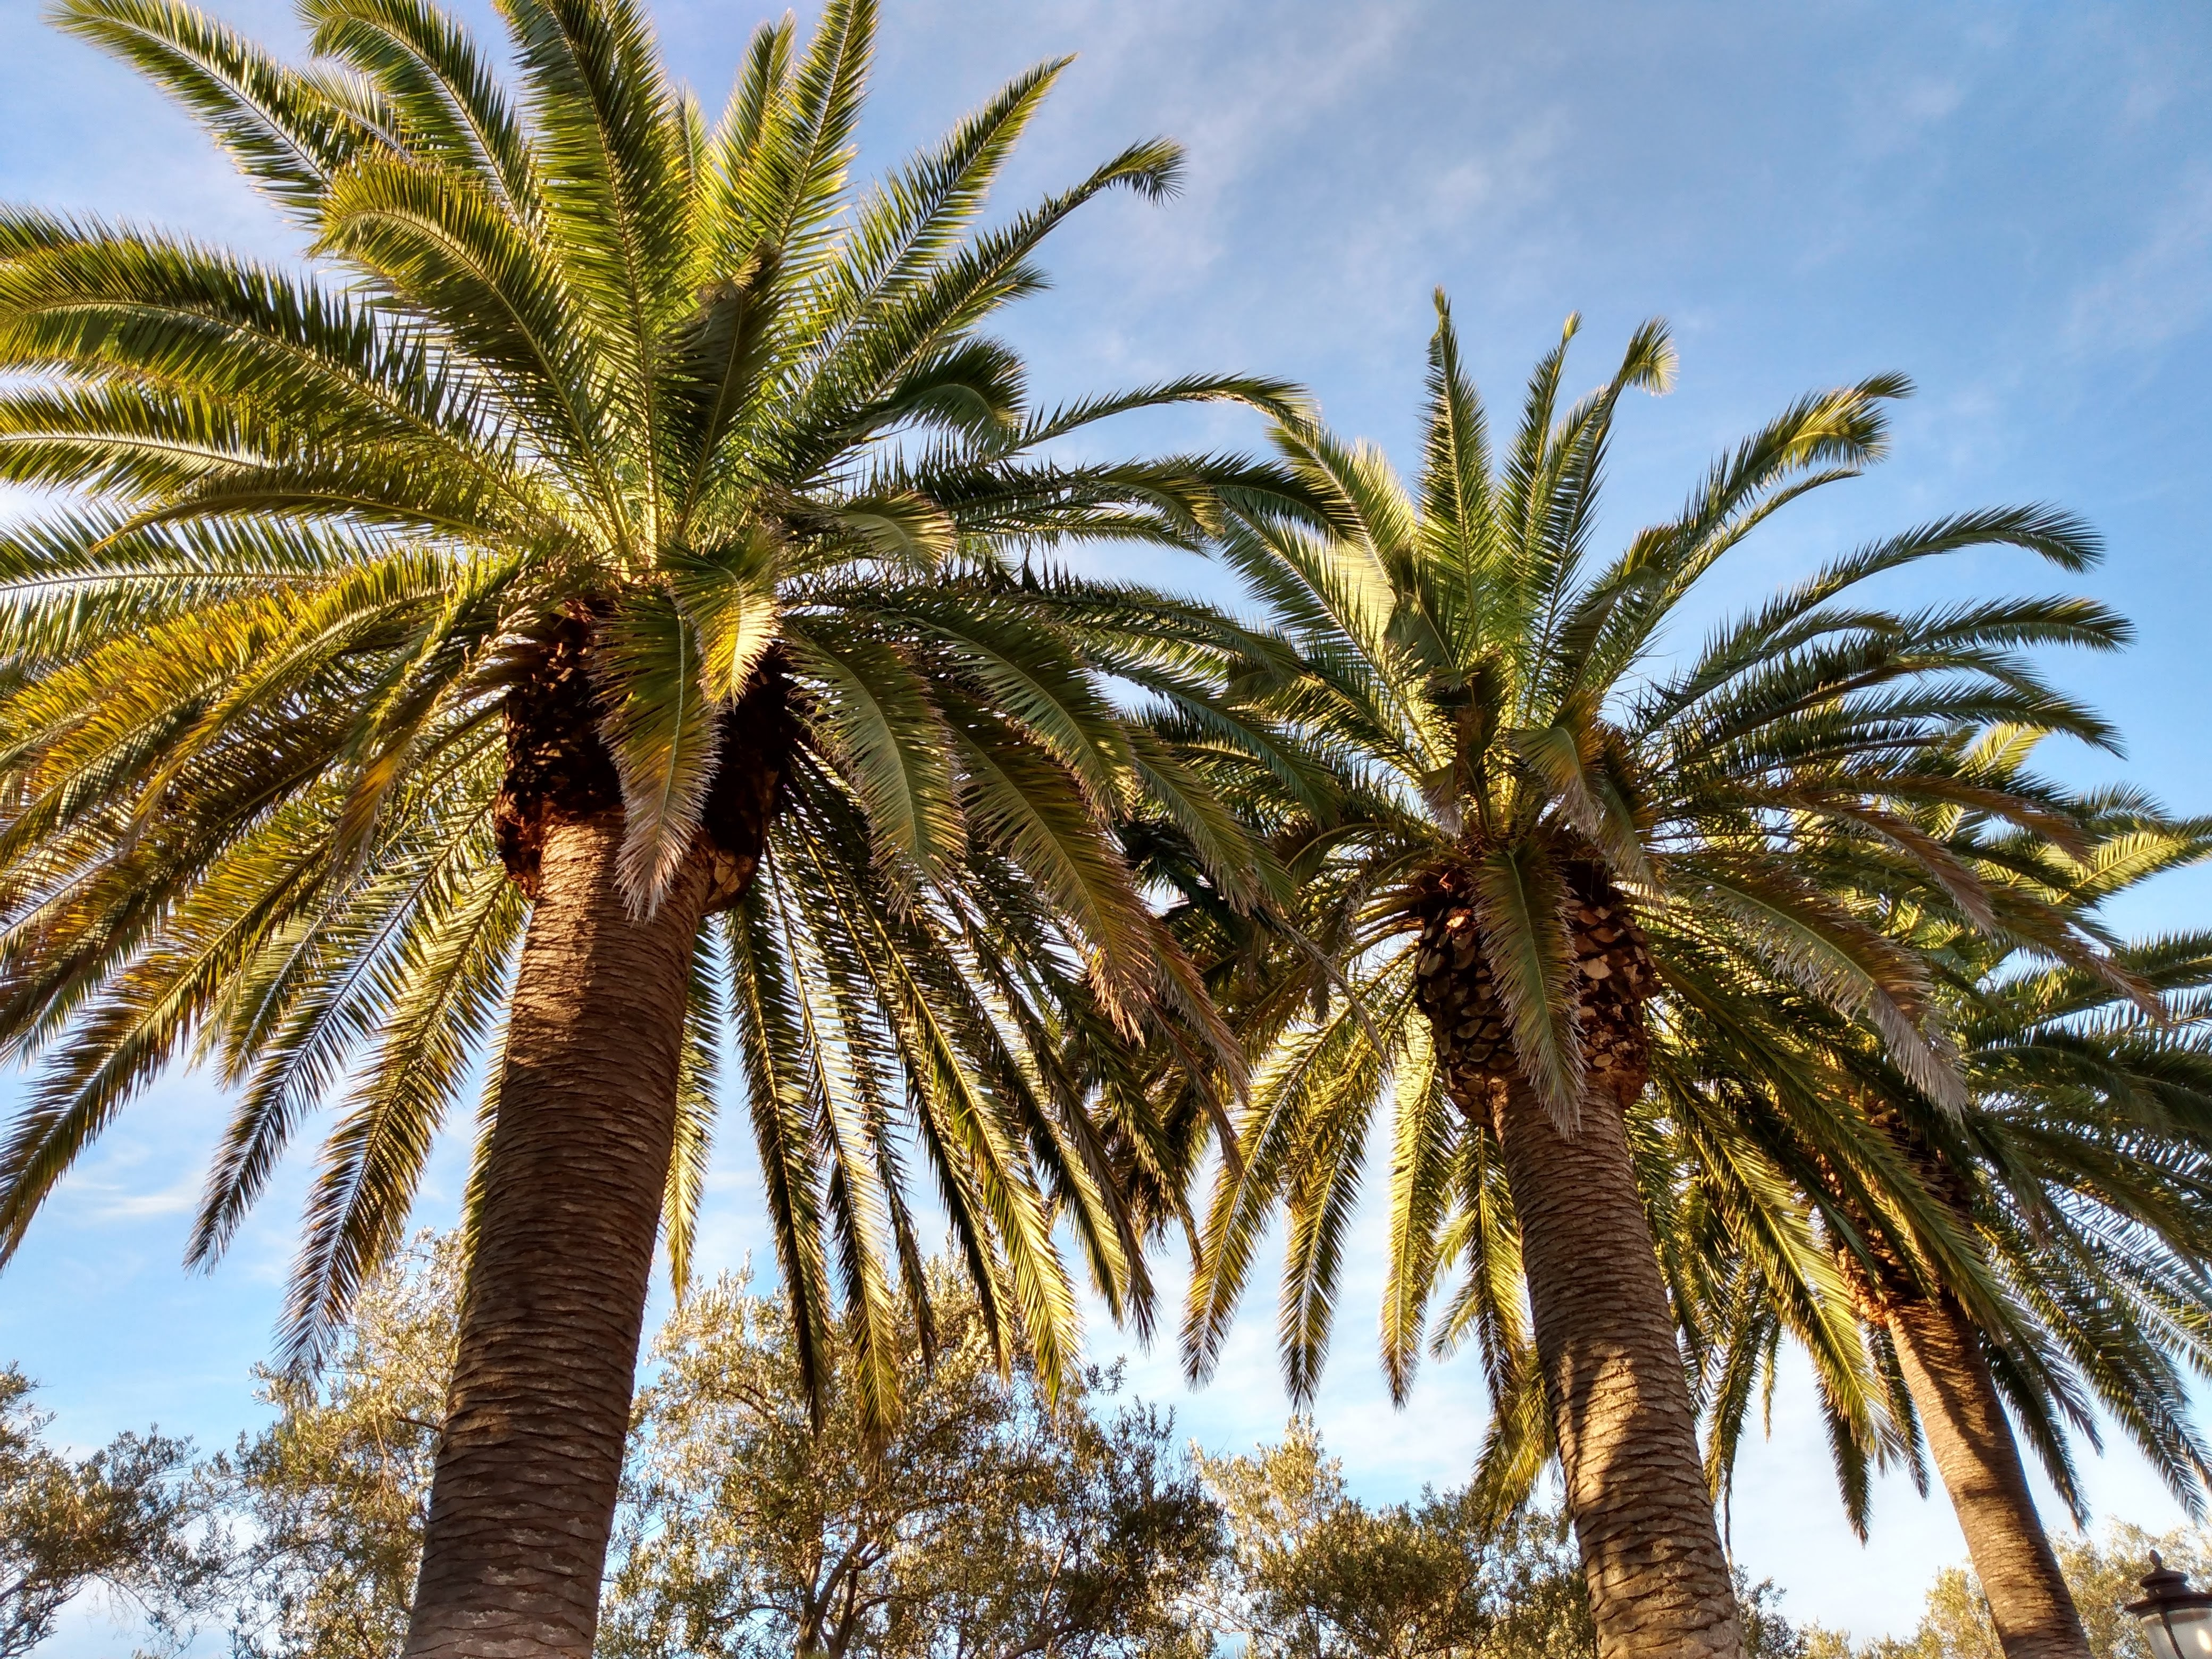

In [1]:
### WARM UP
# a type of neural network that is used for learning about images. 
# Convolutional neural networks or CNNs are used to classify images, 
# cluster images by similarity, and for object recognition in images.
import requests

img_url = "https://raw.githubusercontent.com/LambdaSchool/data-science-canvas-images/main/unit_4/palm_trees.jpg"

r = requests.get(img_url)
with open('palm_trees.jpg', 'wb') as f:
  f.write(r.content)

# Display the first image
from IPython.display import Image
Image(filename='palm_trees.jpg', width=500)

In [2]:
# Example credit: https://pythonexamples.org/python-opencv-image-filter-convolution-cv2-filter2d/

# Imports
import numpy as np
import cv2

# Read in the image
img_src = cv2.imread('palm_trees.jpg')

# Edge detection (high-pass filter)
kernel = np.array([[0.0, -1.0, 0.0], 
                   [-1.0, 4.0, -1.0],
                   [0.0, -1.0, 0.0]])

kernel = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)

# Filter the source image
img_rst = cv2.filter2D(img_src,-1,kernel)

#save result image
cv2.imwrite('palm_trees_edge.jpg', img_rst)

#Image(filename='palm_trees_edge.jpg', width=500)

True

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


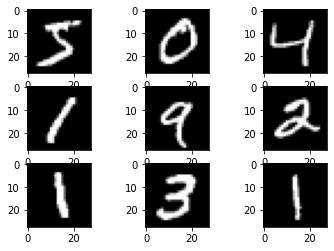

In [3]:
# Some example code from: Machine Learning Mastery
# Imports

from keras.datasets import mnist
import matplotlib.pyplot as plt

# Load the MNIST dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# Look at the training/testing sizes
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

#plot the first nine images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
    
#plt.show
plt.clf;

In [4]:
# Reshape the training images for input into the neural network
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
print(trainX.shape)

# One-hot encode target values to represent the digits between 0 and 9
from keras.utils import to_categorical

trainy = to_categorical(trainy)
testy = to_categorical(testy)

(60000, 28, 28, 1)


The data also need to be scaled so that each pixel has a values between 0 and 1; currently they can have a value between 0 and 255 so we'll just divide by 255.

In [5]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# convert the images
trainX_norm, testX_norm = prep_pixels(trainX, testX)

Now that we have the images ready, we'll set up the model. It will include a convolutional layers, a pooling later, and a few other layers, including the output to correspond to the ten digist we're trying to classify.

In [6]:
# Import keras models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD

# set-up the model
model = Sequential()

# Convolutional layer with a 3x3 kernel
model.add(Conv2D(32, (3, 3), activation='relu',
                kernel_initializer='he_uniform',
                input_shape=(28, 28, 1)))

# pooling layer (takes the max value)
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

# dense hidden layer
model.add(Dense(100, activation='relu',
               kernel_initializer='he_uniform'))

# output layer
model.add(Dense(10, activation='softmax'))

# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',
             metrics=['accuracy'])

In [7]:
# train model
model.fit(trainX_norm, trainy, epochs=5, 
          batch_size=32, validation_data=(testX_norm, testy), 
          verbose=0)

Finally, we'll evaluate on the test set; the second number displayed is the accuracy.

In [8]:
model.evaluate(testX, testy, verbose=0)

[37.13114547729492, 0.9555000066757202]

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('MPU2HistivI', width=600, height=400)

# Convolution & Pooling (Learn)
<a id="p1"></a>

## Overview

Like neural networks themselves, CNNs are inspired by biology - specifically, the receptive fields of the visual cortex.

Put roughly, in a real brain the neurons in the visual cortex *specialize* to be receptive to certain regions, shapes, colors, orientations, and other common visual features. In a sense, the very structure of our cognitive system transforms raw visual input, and sends it to neurons that specialize in handling particular subsets of it.

CNNs imitate this approach by applying a convolution. A convolution is an operation on two functions that produces a third function, showing how one function modifies another. Convolutions have a [variety of nice mathematical properties](https://en.wikipedia.org/wiki/Convolution#Properties) - commutativity, associativity, distributivity, and more. Applying a convolution effectively transforms the "shape" of the input.

One common confusion - the term "convolution" is used to refer to both the process of computing the third (joint) function and the process of applying it. In our context, it's more useful to think of it as an application, again loosely analogous to the mapping from visual field to receptive areas of the cortex in a real animal.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('IOHayh06LJ4', width=600, height=400)

## Follow Along

Let's try to do some convolutions and pooling

### Convolution

Consider blurring an image - assume the image is represented as a matrix of numbers, where each number corresponds to the color value of a pixel.

![](https://lambdaschool-data-science.s3.amazonaws.com/images/Unit4/Sprint2/Module2/Screen+Shot+2020-02-25+at+10.27.17+AM.png)

*Image Credits from __Hands on Machine Learning with Sckit-Learn, Keras & TensorFlow__*


Helpful Terms:
- __Filter__: The weights (parameters) we will apply to our input image.
- __Stride__: How the filter moves across the image
- __Padding__: Zeros (or other values) around the  the input image border (kind of like a frame of zeros). 

In [ ]:
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.exposure import rescale_intensity

austen = io.imread('https://dl.airtable.com/S1InFmIhQBypHBL0BICi_austen.jpg')
austen_grayscale = rescale_intensity(color.rgb2gray(austen))
austen_grayscale.shape

In [ ]:
plt.imshow(austen_grayscale, cmap="gray");

In [ ]:
austen_grayscale.shape

In [ ]:
import numpy as np
import scipy.ndimage as nd

horizontal_edge_convolution = np.array([[1,1,1,1,],
                                        [0,0,0,0],
                                        [0,0,0,0],
                                        [-1,-1,-1,-1]])

vertical_edge_convolution = np.array([[1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1]])

diag_edge_convolution = np.array([[1,0,0,-1],
                                  [0,1,-1,0],
                                  [0,-1,1,0],
                                  [-1,0,0,1]])

austen_edges_vert = nd.convolve(austen_grayscale, diag_edge_convolution)
austen_edges_horz = nd.convolve(austen_grayscale, vertical_edge_convolution)
austen_edges.shape

In [ ]:
plt.imshow(austen_edges_vert, cmap="gray");

In [ ]:
austen_edges.shape

### Pooling Layer

![](https://lambdaschool-data-science.s3.amazonaws.com/images/Unit4/Sprint2/Module2/Screen+Shot+2020-02-25+at+10.26.13+AM.png)

*Image Credits from __Hands on Machine Learning with Sckit-Learn, Keras & TensorFlow__*

We use Pooling Layers to reduce the dimensionality of the feature maps. We get smaller and smaller feature set by apply convolutions and then pooling layers. 

Let's take a look very simple example using Austen's pic. 

In [ ]:
from skimage.measure import block_reduce

reduced = block_reduce(austen_edges, (2,2), np.max)
plt.imshow(reduced, cmap="gray");

In [ ]:
reduced.shape

## Challenge

You will be expected to be able to describe convolution. 

# CNNs for Classification (Learn)

## Overview

### Typical CNN Architecture

![A Typical CNN](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/800px-Typical_cnn.png)

The first stage of a CNN is, unsurprisingly, a convolution - specifically, a transformation that maps regions of the input image to neurons responsible for receiving them. The convolutional layer can be visualized as follows:

![Convolutional layer](https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png)

The red represents the original input image, and the blue the neurons that correspond.

As shown in the first image, a CNN can have multiple rounds of convolutions, [downsampling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (a digital signal processing technique that effectively reduces the information by passing through a filter), and then eventually a fully connected neural network and output layer. Typical output layers for a CNN would be oriented towards classification or detection problems - e.g. "does this picture contain a cat, a dog, or some other animal?"


#### A Convolution in Action

![Convolution](https://miro.medium.com/max/1170/1*Fw-ehcNBR9byHtho-Rxbtw.gif)



Why are CNNs so popular?
1. Compared to prior image learning techniques, they require relatively little image preprocessing (cropping/centering, normalizing, etc.)
2. Relatedly, they are *robust* to all sorts of common problems in images (shifts, lighting, etc.)

Actually training a cutting edge image classification CNN is nontrivial computationally - the good news is, with transfer learning, we can get one "off-the-shelf"!

## Follow Along

In [ ]:
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [ ]:
train_images[0].shape

In [ ]:
train_labels[1]

In [ ]:
32*32*3

In [ ]:
# Setup Architecture

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

In [ ]:
# Compile Model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fit Model
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

In [ ]:
# Evaluate Model

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

## Challenge

You will apply CNNs to a classification task in the module project.

# Transfer Learning for Image Classification (Learn)

## Overview

### Transfer Learning Repositories

#### TensorFlow Hub

"A library for reusable machine learning modules"

This lets you quickly take advantage of a model that was trained with thousands of GPU hours. It also enables transfer learning - reusing a part of a trained model (called a module) that includes weights and assets, but also training the overall model some yourself with your own data. The advantages are fairly clear - you can use less training data, have faster training, and have a model that generalizes better.

https://www.tensorflow.org/hub/

TensorFlow Hub is very bleeding edge, and while there's a good amount of documentation out there, it's not always updated or consistent. You'll have to use your problem-solving skills if you want to use it!

#### Keras API - Applications

> Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

There is a decent selection of important benchmark models. We'll focus on an image classifier: ResNet50.

## Follow Along

In [ ]:
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def process_img_path(img_path):
  return image.load_img(img_path, target_size=(224, 224))

def img_contains_banana(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  print(results)
  for entry in results:
    if entry[1] == 'banana':
      return entry[2]
  return 0.0

In [ ]:
import requests

image_urls = ["https://github.com/LambdaSchool/ML-YouOnlyLookOnce/raw/master/sample_data/negative_examples/example11.jpeg",
              "https://github.com/LambdaSchool/ML-YouOnlyLookOnce/raw/master/sample_data/positive_examples/example0.jpeg"]

for _id,img in enumerate(image_urls): 
    r = requests.get(img)
    with open(f'example{_id}.jpg', 'wb') as f:
        f.write(r.content)

In [ ]:
from IPython.display import Image
Image(filename='./example0.jpg', width=600)

In [ ]:
img_contains_banana(process_img_path('example0.jpg'))

In [ ]:
Image(filename='example1.jpg', width=600)

In [ ]:
img_contains_banana(process_img_path('example1.jpg'))

Notice that, while it gets it right, the confidence for the banana image is fairly low. That's because so much of the image is "not-banana"! How can this be improved? Bounding boxes to center on items of interest.

## Challenge

You will be expected to apply a pretrained model to a classificaiton problem today. 

# Review

- <a href="#p1">Part 1: </a>Describe convolution and pooling
    * A Convolution is a function applied to another function to produce a third function
    * Convolutional Kernels are typically 'learned' during the process of training a Convolution Neural Network
    * Pooling is a dimensionality reduction technique that uses either Max or Average of a feature map region to downsample data
- <a href="#p2">Part 2: </a>Apply a convolutional neural network to a classification task
    * Keras has layers for convolutions :) 
- <a href="#p3">Part 3: </a>Transfer Learning for Image Classification
    * Check out both pretinaed models available in Keras & TensorFlow Hub

# Sources

- *_Deep Learning_*. Goodfellow *et al.*
- *Hands-on Machine Learnign with Scikit-Learn, Keras & Tensorflow*
- [Keras CNN Tutorial](https://www.tensorflow.org/tutorials/images/cnn)
- [Tensorflow + Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [Convolution Wiki](https://en.wikipedia.org/wiki/Convolution)
- [Keras Conv2D: Working with CNN 2D Convolutions in Keras](https://missinglink.ai/guides/keras/keras-conv2d-working-cnn-2d-convolutions-keras/)
- [Intuitively Understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)
- [A Beginner's Guide to Understanding Convolutional Neural Networks Part 2](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)